# Preliminaries

In [86]:
import copy
import itertools
from collections import defaultdict
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt

# PrefixSpan

### Project a sequence

In [2]:
"""
Projects a sequence according to a given prefix, as done in PrefixSpan

Args:
    sequence: the sequence the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first itemset is ignored
Returns:
    If the sequence does not contain the prefix, then None.
    Otherwise, a new sequence starting from the position of the prefix, including the itemset that includes the prefix
"""
def projectSequence(sequence, prefix, newEvent):
    result = None
    for i, itemset in enumerate(sequence):
        if result is None:
            if (not newEvent) or i > 0:
                if (all(x in itemset for x in prefix)):
                    result = [list(itemset)]
        else:
            result.append(copy.copy(itemset))
    return result

### Project a dataset

In [3]:
"""
Projects a dataset according to a given prefix, as done in PrefixSpan

Args:
    dataset: the dataset the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first itemset is ignored
Returns:
    A (potentially empty) list of sequences
"""
def projectDatabase(dataset, prefix, newEvent):
    projectedDB = []
    for sequence in dataset:
        seqProjected = projectSequence(sequence, prefix, newEvent)
        if not seqProjected is None:
            projectedDB.append(seqProjected)
    return projectedDB

### The main algorithm

#### Some more utility functions:

In [4]:
"""
Generates a list of all items that are contained in a dataset
"""
def generateItems(dataset):
    return sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))

"""
Computes a defaultdict that maps each item in the dataset to its support
"""
def generateItemSupports(dataset, ignoreFirstEvent=False, prefix=[]):
    result = defaultdict(int)
    for sequence in dataset:
        if ignoreFirstEvent:
            sequence = sequence[1:]
        cooccurringItems = set()
        for itemset in sequence:
            if all(x in itemset for x in prefix):
                for item in itemset:
                    if not item in prefix:
                        cooccurringItems.add(item)
        for item in cooccurringItems:
            result [item] += 1
    return sorted(result.items())

#### Finally, the algorithm:

In [5]:
"""
The PrefixSpan algorithm. Computes the frequent sequences in a seqeunce dataset for a given minSupport

Args:
    dataset: A list of sequences, for which the frequent (sub-)sequences are computed
    minSupport: The minimum support that makes a sequence frequent
Returns:
    A list of tuples (s, c), where s is a frequent sequence, and c is the count for that sequence
"""
def prefixSpan(dataset, minSupport):
    result = []
    itemCounts = generateItemSupports(dataset)
    for item, count in itemCounts:
        if count >= minSupport:
            newPrefix = [[item]]
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], False), minSupport, newPrefix))
    return result

def prefixSpanInternal(dataset, minSupport, prevPrefixes=[]):
    result = []
    
    # Add a new item to the last element (==same time)
    itemCountSameEvent = generateItemSupports(dataset, False, prefix=prevPrefixes[-1])
    for item, count in itemCountSameEvent:
        if (count >= minSupport) and item > prevPrefixes[-1][-1]:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix[-1].append(item)
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, newPrefix[-1], False), minSupport, newPrefix))
        
    # Add a new event to the prefix
    itemCountSubsequentEvents = generateItemSupports(dataset, True)
    for item, count in itemCountSubsequentEvents:
        if count >= minSupport:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix.append([item])
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], True), minSupport, newPrefix))
    return result

# Filter for closed and maximal patterns
### Closed patterns

In [6]:
"""
Given a list of all frequent sequences and their counts, compute the set of closed frequent sequence (as a list)
This is only a very simplistic (naive) implementation for demonstration purposes!
"""
def filterClosed(result):
    for supersequence, countSeq in copy.deepcopy(result):
        for subsequence, countSubSeq in copy.deepcopy(result):
            if isSubsequence(supersequence, subsequence) and (countSeq == countSubSeq) and subsequence != supersequence:
                result.remove((subsequence, countSubSeq))

### Maximal sequences

In [7]:
"""
Given a list of all frequent sequences and their counts, compute the set of maximal frequent sequence (as a list)
This is only a very naive implementation for demonstration purposes!
"""
def filterMaximal(result):
    for supersequence, countSeq in copy.deepcopy(result):
        for subsequence, countSubSeq in copy.deepcopy(result):
            if isSubsequence (supersequence, subsequence) and subsequence != supersequence:
                result.remove((subsequence, countSubSeq)) 

# Application 

In [8]:
df = pd.read_csv(r'/Users/clothildedevillenfagne/Cours/Master_2/Memoire/moyen_data.csv', sep="\t")

/Users/clothildedevillenfagne/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9,10,14,16,17,37,38,39,40,41,43,44,45,46,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
new_df = df[df['class']=='Aves']
new_df = new_df[['family','species', 'year', 'month', 'decimalLatitude', 'decimalLongitude', 'individualCount']]

In [10]:
region = pd.read_csv('/Users/clothildedevillenfagne/Cours/Master_2/Memoire/region_obs_oiseaux.csv')
new_df['region']=region['0'].tolist()
new_df = new_df[new_df['region']=='Région de Bruxelles-Capitale']

In [ ]:
len(set(new_df['family'].tolist()))

In [22]:
len(new_df)

546436

### Regarder pour les espèce

In [11]:
def ps_for_year(df):
    resultat_final=[]
    #df_use = df[df['year']==annee]
    year = set(df['year'].tolist())
    #gen = list(set(df['species'].tolist()))
    
    for ye in year:
        data1 = df[df.year == ye]
        print('année :', ye)
        #print(data1)
        month = set(data1['month'].tolist())
        new_month = []
        count = False
        for elem in month:
            if pd.isnull(elem):
                count = True
            else:
                new_month.append(elem)
            if count == True:
                new_month.append(float('nan'))
        month = new_month
        big_list =[]
        for mo in month:
            data2 = data1[data1.month == mo]
            longitude = set(data2['decimalLongitude'].tolist())
            print('mois :', mo)
            for lon in longitude:
                data3 = data2[data2.decimalLongitude == lon]
                latitude = set(data3['decimalLatitude'].tolist())
                for la in latitude:  # d'abord refaire un for pour longitude puis latitude
                    lst = []#[0] * len(gen) #np.nan
                    final_df = data3[data3.decimalLatitude == la]
                    #print(final_df)
                    # num_obs = len(final_df['decimalLatitude'])
                    genre = set(final_df['family'].tolist())
                    for elem in genre:
                        if pd.isnull(elem) == False:
                        #index = gen.index(elem)
                        #lst[index]+=1
                            lst.append(elem)

                    big_list.append(lst)
        wikispeediaData=[]
        for seq in big_list:
            newSeq = []
            for item in seq:
                newSeq.append([item])
            wikispeediaData.append(newSeq)
        min_sup = len(wikispeediaData)*10/100
        res = prefixSpan (wikispeediaData, min_sup)
        resultat = []
        for elem in res:
            resultat.append(elem+(ye,))
        resultat_final.extend(resultat)
    return resultat_final

In [12]:
res = ps_for_year(new_df)

année : 2000
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0
mois : 10.0
mois : 11.0
mois : 12.0
année : 2001
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0
mois : 10.0
mois : 11.0
mois : 12.0
année : 2002
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0
mois : 10.0
mois : 11.0
mois : 12.0
année : 2003
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0
mois : 10.0
mois : 11.0
mois : 12.0
année : 2004
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0
mois : 10.0
mois : 11.0
mois : 12.0
année : 2005
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0
mois : 10.0
mois : 11.0
mois : 12.0
année : 2006
mois : 1.0
mois : 2.0
mois : 3.0
mois : 4.0
mois : 5.0
mois : 6.0
mois : 7.0
mois : 8.0
mois : 9.0


In [13]:
res

[([['Accipitridae']], 16, 2000),
 ([['Anatidae']], 33, 2000),
 ([['Columbidae']], 13, 2000),
 ([['Corvidae']], 11, 2000),
 ([['Fringillidae']], 14, 2000),
 ([['Laridae']], 14, 2000),
 ([['Motacillidae']], 16, 2000),
 ([['Motacillidae'], ['Turdidae']], 10, 2000),
 ([['Muscicapidae']], 11, 2000),
 ([['Phalacrocoracidae']], 12, 2000),
 ([['Phylloscopidae']], 11, 2000),
 ([['Picidae']], 13, 2000),
 ([['Psittacidae']], 15, 2000),
 ([['Rallidae']], 12, 2000),
 ([['Scolopacidae']], 10, 2000),
 ([['Sylviidae']], 11, 2000),
 ([['Turdidae']], 17, 2000),
 ([['Accipitridae']], 11, 2001),
 ([['Accipitridae'], ['Falconidae']], 8, 2001),
 ([['Anatidae']], 18, 2001),
 ([['Anatidae'], ['Fringillidae']], 6, 2001),
 ([['Falconidae']], 15, 2001),
 ([['Fringillidae']], 13, 2001),
 ([['Fringillidae'], ['Accipitridae']], 8, 2001),
 ([['Fringillidae'], ['Accipitridae'], ['Falconidae']], 7, 2001),
 ([['Fringillidae'], ['Falconidae']], 8, 2001),
 ([['Fringillidae'], ['Scolopacidae']], 6, 2001),
 ([['Hirundinida

## Traitement des résultat

In [14]:
final =[] 
for i in range(len(res)):
    longueur = len(res[i][0])
    pattern = []
    for j in range(longueur):
        elem = res[i][0][j][0]
        pattern.append(elem)
        b = frozenset(pattern)
    c = (b, res[i][1], res[i][2])
    final.append(c)

In [16]:
df_prefix = pd.DataFrame(final, columns =['espece', 'compte', 'annee'])

In [18]:
ar = []
espece = set(df_prefix['espece'].tolist())
for element in espece:
    df_1 = df_prefix[df_prefix['espece']==element]
    list_annee = []
    list_count = []
    for el in df_1.itertuples():
        list_annee.append(el.annee)
        list_count.append(el.compte)
    list_pat = [element,df_1['compte'].sum() ,list_count, list_annee, len(set(list_annee))]
    ar.append(list_pat)
    

In [19]:
df_prefixSpan = pd.DataFrame(ar, columns =['espèce', 'compte_total','compte', 'année', 'nombre_annee'])

In [20]:
final_prefix = df_prefixSpan.sort_values(['nombre_annee', 'compte_total'], ascending = [False,False])

In [21]:
final_prefix

,espèce,compte_total,compte,année,nombre_annee
114,(Anatidae),15704,"[33, 18, 20, 28, 53, 46, 17, 31, 123, 540, 711...","[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",22
90,(Psittacidae),14785,"[15, 7, 6, 9, 35, 11, 69, 360, 456, 504, 557, ...","[2000, 2001, 2002, 2003, 2004, 2005, 2008, 200...",20
217,(Columbidae),10550,"[13, 12, 13, 16, 7, 11, 49, 130, 160, 284, 627...","[2000, 2003, 2004, 2005, 2006, 2007, 2008, 200...",18
83,(Fringillidae),221,"[14, 13, 18, 17, 22, 22, 25, 26, 64]","[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",9
104,(Motacillidae),203,"[16, 13, 15, 22, 21, 25, 21, 21, 49]","[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",9
...,...,...,...,...,...
4,"(Muscicapidae, Scolopacidae)",6,[6],[2001],1
183,"(Scolopacidae, Phylloscopidae)",6,[6],[2001],1
220,"(Hirundinidae, Accipitridae)",6,[6],[2001],1
222,"(Falconidae, Scolopacidae)",6,[6],[2001],1


In [ ]:
#final_prefix.to_csv('res_prefix.csv')

# regarder taux de croissance famille bx

In [23]:
new_df

,family,species,year,month,decimalLatitude,decimalLongitude,individualCount,region
480,Anatidae,Alopochen aegyptiaca,2021,4.0,50.81495,4.29600,2.0,Région de Bruxelles-Capitale
510,Psittacidae,Psittacula krameri,2021,4.0,50.84976,4.42394,12.0,Région de Bruxelles-Capitale
572,Anatidae,Alopochen aegyptiaca,2021,4.0,50.88660,4.29821,9.0,Région de Bruxelles-Capitale
642,Psittacidae,Psittacula krameri,2021,4.0,50.83718,4.37346,1.0,Région de Bruxelles-Capitale
659,Psittacidae,Psittacula krameri,2021,4.0,50.83802,4.37824,5.0,Région de Bruxelles-Capitale
...,...,...,...,...,...,...,...,...
22563290,Turdidae,Turdus pilaris,2018,11.0,50.88094,4.38597,20.0,Région de Bruxelles-Capitale
22563310,Muscicapidae,Erithacus rubecula,2018,11.0,50.83513,4.45563,1.0,Région de Bruxelles-Capitale
22563316,Corvidae,Coloeus monedula,2018,11.0,50.83599,4.38464,1.0,Région de Bruxelles-Capitale
22563380,Troglodytidae,Troglodytes troglodytes,2017,3.0,50.83513,4.45563,1.0,Région de Bruxelles-Capitale


In [36]:
family = set(new_df['family'].tolist()) #63 famille différente 
taux_croissance = []
for fam in family:
    data1 = new_df[new_df['family']==fam]
    year = set(data1['year'].tolist())
    for ye in year:
        data2 = data1[data1['year']==ye]
        count = (data2['individualCount'].sum())/len(new_df[new_df['year']==ye]) # normalisation
        list_count = [fam, ye, count]
        taux_croissance.append(list_count)
df_taux = pd.DataFrame(taux_croissance, columns=['family', 'year', 'count'] )        

In [26]:
year = set(new_df['year'].tolist()) #63 famille différente 
taux_croissance = []
for ye in year:
    data1 = new_df[new_df['year']==ye]
    family = set(data1['family'].tolist())
    norm = data1['individualCount'].sum()
    for fam in family:
        data2 = data1[data1['family']==fam]
        count = (data2['individualCount'].sum()/norm) # normalisation
        list_count = [fam, ye, count]
        taux_croissance.append(list_count)
df_taux = pd.DataFrame(taux_croissance, columns=['family', 'year', 'count'] ) 

In [27]:
df_taux

,family,year,count
0,NaN,2000,0.000000
1,Ardeidae,2000,0.000018
2,Aegithalidae,2000,0.000018
3,Podicipedidae,2000,0.000018
4,Sturnidae,2000,0.008123
...,...,...,...
895,Columbidae,2021,0.207665
896,Estrildidae,2021,0.000343
897,Phasianidae,2021,0.007404
898,Psittacidae,2021,0.284519


In [29]:
df_taux[df_taux['family']=='Psittacidae']#Passeridae Psittacidae

,family,year,count
24,Psittacidae,2000,0.139877
67,Psittacidae,2001,0.105657
108,Psittacidae,2002,0.004694
147,Psittacidae,2003,0.007024
188,Psittacidae,2004,0.120822
228,Psittacidae,2005,0.039079
268,Psittacidae,2006,0.000075
309,Psittacidae,2007,0.002997
356,Psittacidae,2008,0.031710
401,Psittacidae,2009,0.042486


In [90]:
df_taux_10 = df_taux[df_taux['year']>=2009]
df_taux_10 = df_taux_10[df_taux_10['year']<2019]

In [91]:
df_taux_10[df_taux_10['family']=='Phasianidae']

,family,year,count
89,Phasianidae,2016,0.002690
90,Phasianidae,2017,0.001057
91,Phasianidae,2018,0.001563
100,Phasianidae,2009,0.002281
101,Phasianidae,2010,0.003037
102,Phasianidae,2011,0.005786
103,Phasianidae,2012,0.004755
104,Phasianidae,2013,0.004518
105,Phasianidae,2014,0.002076
106,Phasianidae,2015,0.002288


In [99]:
dico_croissance_neg = {}
dico_croissance_pos = {}
dico_total = {}
for fam in set(df_taux_10['family'].tolist()):
    data1 = df_taux_10[df_taux_10['family']==fam]
    data1 = data1.sort_values(by=['year'])
    count_list = data1['count'].tolist()
    year = data1['year'].tolist()
    somme = 0
    count = 1
    dico = {}
    for i in range(1, len(count_list)):
        dico[year[i]] = (count_list[i]-count_list[i-1])/count_list[i-1]
        somme += (count_list[i]-count_list[i-1])/count_list[i-1]
        count+=1
    dico_total[fam]=dico
    moyen = somme/count
    if count >= 10:
        if moyen <0:
            dico_croissance_neg[fam]=(moyen, count)
        else:
            dico_croissance_pos[fam]=(moyen, count)

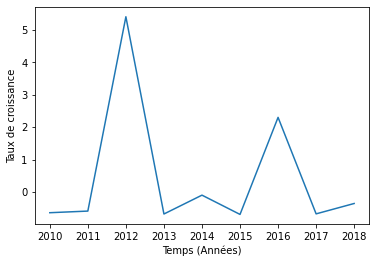

In [103]:
def to_graph(family, dico):
    key = list(dico[family].keys())
    value = list(dico[family].values())
    plt.plot(key, value)
    plt.xlabel('Temps (Années)')
    plt.ylabel('Taux de croissance')
    plt.savefig('taux_'+family+'.png')
    
to_graph('Alaudidae', dico_total)

In [101]:
sorted(dico_croissance_neg.items(), key=lambda item: item[1])

[('Motacillidae', (-0.14093951356132747, 10)),
 ('Hirundinidae', (-0.1296403485533461, 10)),
 ('Phylloscopidae', (-0.12129573830928217, 10)),
 ('Anatidae', (-0.09290152936556022, 10)),
 ('Sylviidae', (-0.08868478387667753, 10)),
 ('Phalacrocoracidae', (-0.08638660405028153, 10)),
 ('Charadriidae', (-0.07721313862175357, 10)),
 ('Accipitridae', (-0.07380226420029098, 10)),
 ('Scolopacidae', (-0.07324149795167134, 10)),
 ('Columbidae', (-0.06669747733638501, 10)),
 ('Laridae', (-0.054212323000007834, 10)),
 ('Falconidae', (-0.05330031520194497, 10)),
 ('Ardeidae', (-0.05100907869597672, 10)),
 ('Sturnidae', (-0.046415520379279845, 10)),
 ('Corvidae', (-0.04381958071124849, 10)),
 ('Prunellidae', (-0.03493762567259935, 10)),
 ('Aegithalidae', (-0.030880968612721004, 10)),
 ('Turdidae', (-0.024542909751470617, 10)),
 ('Passeridae', (-0.023044534213474965, 10)),
 ('Picidae', (-0.016009803587926433, 10)),
 ('Podicipedidae', (-0.012455709196065787, 10)),
 ('Certhiidae', (-0.005296966316103999

In [102]:
sorted(dico_croissance_pos.items(), key=lambda item: item[1], reverse=True)

[('Gruidae', (5.388055703943101, 10)),
 ('Alaudidae', (0.39758893515425353, 10)),
 ('Psittacidae', (0.3034893313636284, 10)),
 ('Ciconiidae', (0.296249119945152, 10)),
 ('Fringillidae', (0.13724211481569934, 10)),
 ('Apodidae', (0.13678546569488897, 10)),
 ('Alcedinidae', (0.11425927718092307, 10)),
 ('Troglodytidae', (0.07412697904575538, 10)),
 ('Strigidae', (0.07133202419469017, 10)),
 ('Phasianidae', (0.06174580981067288, 10)),
 ('Emberizidae', (0.046453248249569735, 10)),
 ('Acrocephalidae', (0.03163981366188229, 10)),
 ('Paridae', (0.028061302635087625, 10)),
 ('Muscicapidae', (0.02031655726276826, 10))]

In [104]:
df_temp = new_df[new_df['year']>=2009]
df_temp = df_temp[df_temp['year']<2019]

df_temp = df_temp[df_temp['family']=='Alaudidae']
print(df_temp)

             family          species  year  month  decimalLatitude  \
312360    Alaudidae  Alauda arvensis  2018   10.0         50.83513   
321347    Alaudidae  Alauda arvensis  2010   10.0         50.79018   
323944    Alaudidae  Alauda arvensis  2014   10.0         50.79018   
324870    Alaudidae  Alauda arvensis  2015   11.0         50.88094   
332600    Alaudidae  Alauda arvensis  2015   10.0         50.88176   
...             ...              ...   ...    ...              ...   
22524354  Alaudidae  Alauda arvensis  2018   10.0         50.88094   
22535900  Alaudidae  Alauda arvensis  2014    9.0         50.79018   
22539890  Alaudidae  Alauda arvensis  2018   10.0         50.88094   
22549842  Alaudidae  Alauda arvensis  2011    9.0         50.79018   
22560142  Alaudidae  Lullula arborea  2015   10.0         50.88094   

          decimalLongitude  individualCount                        region  
312360             4.45563              1.0  Région de Bruxelles-Capitale  
321347 

In [66]:
df_temp['species'].tolist()

['Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Gallus gallus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus',
 'Phasianus colchicus'